In [1]:
%matplotlib inline

In [2]:
pwd

'/Volumes/Work/starclass/Notebooks'

In [3]:
import sys
#sys.path.append('../../../non_corrupt_starclass/starclass')
sys.path.append('../')
#sys.path.append('../../../shap/')

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
import pickle
import sqlite3
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import shap
shap.initjs()

[<matplotlib.lines.Line2D at 0x127490510>]

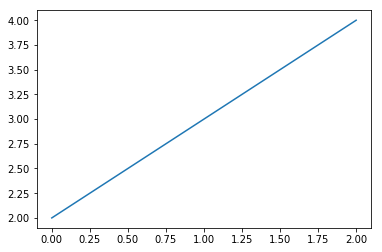

In [7]:
plt.plot([0, 1, 2], [2, 3, 4])

In [8]:
connection = sqlite3.connect('../starclass/training_sets/data/keplerq9/todo.sqlite')

In [9]:
df = pd.read_sql_query("select * from starclass;", connection)
labels = pd.read_sql_query("select * from diagnostics;", connection)
labels['label'] = [i.split('/')[0] for i in labels['lightcurve'].values]
print(labels.head(10))
#print(df.head(10))
connection.close()

   priority     starid               lightcurve  elaptime     mean_flux  \
0         1  201131882  APERIODIC/201131882.txt  3.659683  5.551115e-11   
1         2  201132839  APERIODIC/201132839.txt  3.847908 -5.551115e-11   
2         3  201133037  APERIODIC/201133037.txt  2.893283 -5.551115e-11   
3         4  201141142  APERIODIC/201141142.txt  3.018105 -5.551115e-11   
4         5  201142064  APERIODIC/201142064.txt  3.727106  0.000000e+00   
5         6  201142448  APERIODIC/201142448.txt  3.184177 -5.551115e-11   
6         7  201147037  APERIODIC/201147037.txt  3.313966  0.000000e+00   
7         8  201150637  APERIODIC/201150637.txt  3.559624  0.000000e+00   
8         9  201153558  APERIODIC/201153558.txt  3.188357 -5.551115e-11   
9        10  201154950  APERIODIC/201154950.txt  2.583343  5.551115e-11   

       variance  variability  mask_size  pos_row  pos_column  contamination  \
0  1.309640e+06   892.888975        350      0.0         0.0            0.0   
1  1.152794e+06 

In [10]:
labels['priority'].iloc[3800:4200]

3800    3801
3801    3802
3802    3803
3803    3804
3804    3805
3805    3806
3806    3807
3807    3808
3808    3809
3809    3810
3810    3811
3811    3812
3812    3813
3813    3814
3814    3815
3815    3816
3816    3817
3817    3818
3818    3819
3819    3820
3820    3821
3821    3822
3822    3823
3823    3824
3824    3825
3825    3826
3826    3827
3827    3828
3828    3829
3829    3830
3830    3831
3831    3832
3832    3833
3833    3834
3834    3835
3835    3836
3836    3837
3837    3838
3838    3839
3839    3840
3840    3841
3841    3842
3842    3843
3843    3844
3844    3845
3845    3846
3846    3847
3847    3848
3848    3849
3849    3850
3850    3851
3851    3852
3852    3853
3853    3854
3854    3855
3855    3856
3856    3857
3857    3858
3858    3859
3859    3860
3860    3861
3861    3862
3862    3863
3863    3864
3864    3865
3865    3866
3866    3867
3867    3868
3868    3869
3869    3870
3870    3871
3871    3872
3872    3873
3873    3874
3874    3875
3875    3876
3876    3877

In [11]:
y = labels['label'].astype('U15').values #values[labels['priority'].unique()-1].astype('U15')
priority = labels['priority'].values#[df['priority'].unique()-1]
y[y == 'APERIODIC'] = 'aperiodic'
y[y == 'CONSTANT'] = 'constant'
y[y == 'RRLYR_CEPHEID'] = 'RRLyr/Ceph'
y[y == 'CONTACT_ROT'] = 'contactEB/spots'
y[y == 'DSCT_BCEP'] = 'dSct/bCep'
y[y == 'ECLIPSE'] = 'transit/eclipse'
y[y == 'GDOR_SPB'] = 'gDor/spB'
y[y == 'SOLARLIKE'] = 'solar'

In [12]:
len(priority), len(y), len(df)

(5755, 5755, 9232)

In [13]:
rfgc = df.loc[(df['classifier'] == 'rfgc'), ]#.values.reshape(len(df)//32, 8)
#slosh = df.loc[(df['classifier'] == 'slosh'), 'prob'].values.reshape(len(df)//32, 8)
#xgb = df.loc[(df['classifier'] == 'xgb'), 'prob'].values.reshape(len(df)//32, 8)

In [14]:
feature_names = [r'$f_{1}$', r'$f_{2}$', r'$f_{3}$', r'$f_{4}$', r'$f_{5}$', r'$f_{6}$', r'$A_{21}$', r'$A_{31}$', r'$\phi_{21}$', r'$\phi_{31}$', 
                 'SOM location 1', 'SOM location 2', r'$\phi$ p2p98', r'$\phi$ p2p mean', 'p2p98', 'p2p mean', r'$\psi^{2}$', 'Zero-crossings', r'$F_{p}07$', r'$F_{p}7$', r'$F_{p}20$', r'$F_{p}50$']
class_names = ['RR Lyr/Cepheid', 'Aperiodic', 'Constant', 
                      'Contact binaries/rotation', r'$\delta$ Sct/$\beta$ Cep', '$\gamma$ Dor/SPB', 
                      'Solar-like', 'Eclipsing/Transiting']

In [15]:
with open('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
#model = pickle.load('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle')

KeyboardInterrupt: 

In [78]:
X = np.zeros([len(priority), 22])
for idx, i in enumerate(priority):
    X[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')

In [127]:
X_old = np.zeros([len(priority), 22])
for idx, i in enumerate(priority):
    try:
        X_old[idx,:] = np.loadtxt('../../non_corrupt_starclass/starclass/starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
    except:
        pass

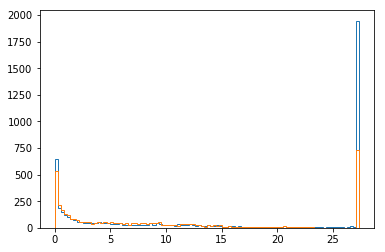

In [129]:
plt.hist(X[:,0], bins=100, histtype='step');
plt.hist(X_old[X_old[:,0] != 0,0], bins=100, histtype='step');
plt.show()

In [130]:
bad_stars = priority[X[:,0] > 27]
bad_stars

array([  37,   39,   45, ..., 5710, 5714, 5725])

In [131]:
len(y)

5179

In [132]:
bad_stars[-1]

5725

In [16]:
priority[y == 'RRLyr/Ceph']

array([3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999,
       4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010,
       4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021,
       4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032,
       4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043,
       4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051])

In [20]:
import matplotlib


9.193490791008498
priority                                  3990
starid                                      -1
lightcurve       RRLYR_CEPHEID/fakerrlyr_1.txt
elaptime                               3.36409
mean_flux                          1.11072e-10
variance                           1.06121e+11
variability                             201557
mask_size                                  350
pos_row                                      0
pos_column                                   0
contamination                                0
stamp_resizes                                0
errors                                    None
eclon                                        0
eclat                                        0
label                            RRLYR_CEPHEID
Name: 3989, dtype: object
0.7101111189937498
priority                                  3991
starid                                      -1
lightcurve       RRLYR_CEPHEID/fakerrlyr_2.txt
elaptime                               3.112

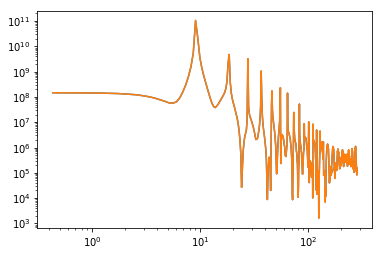

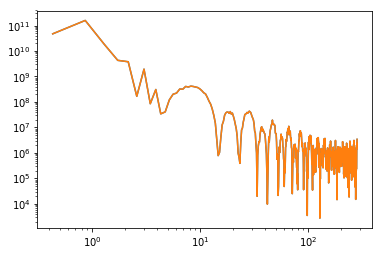

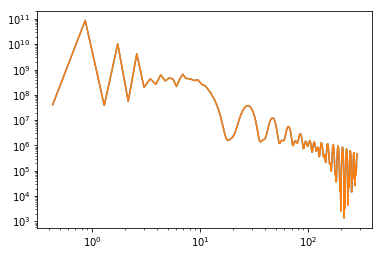

<Figure size 432x288 with 0 Axes>

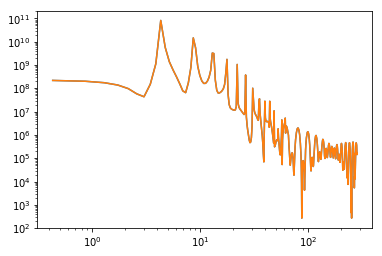

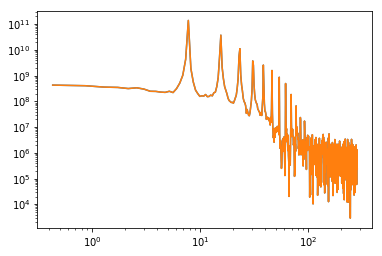

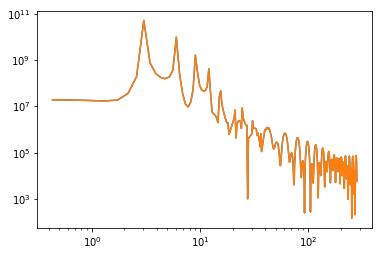

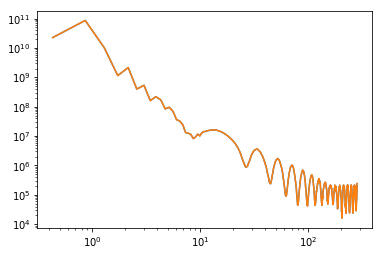

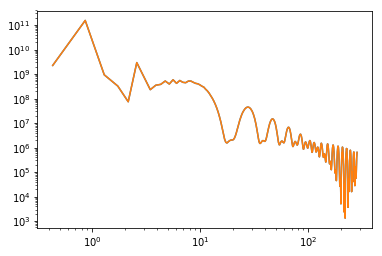

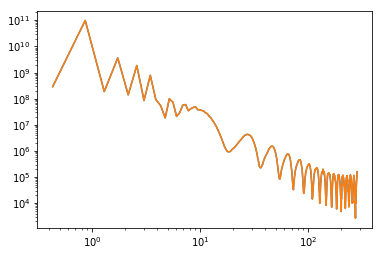

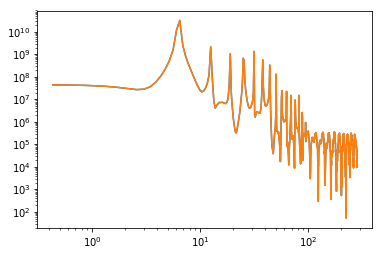

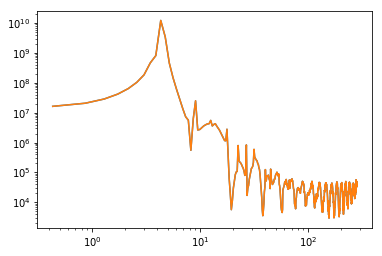

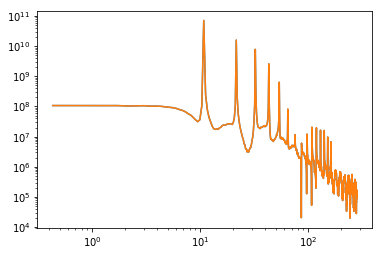

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

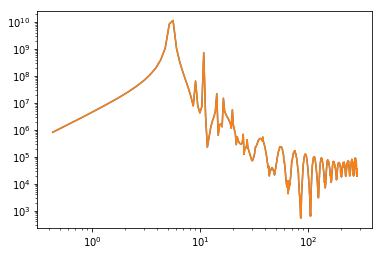

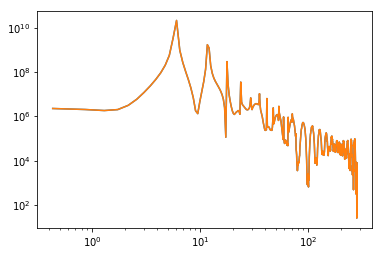

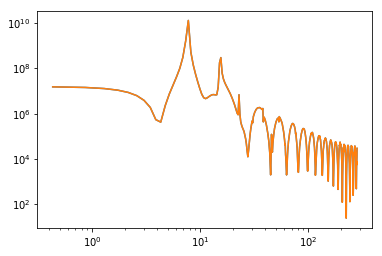

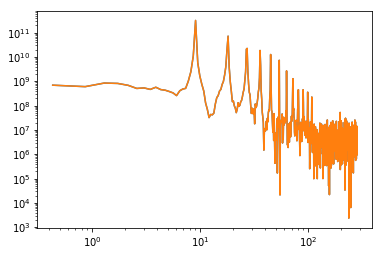

<Figure size 432x288 with 0 Axes>

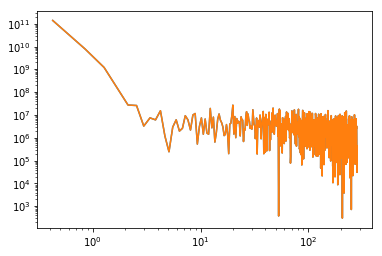

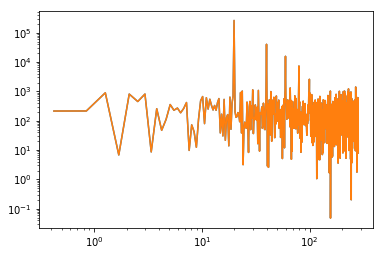

<Figure size 432x288 with 0 Axes>

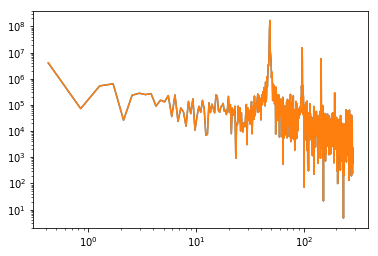

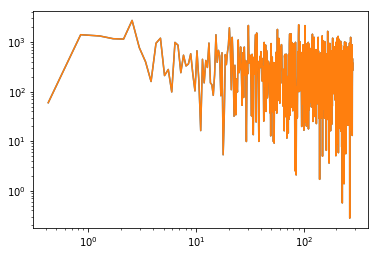

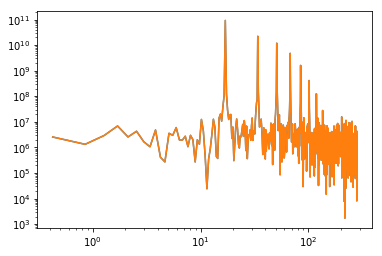

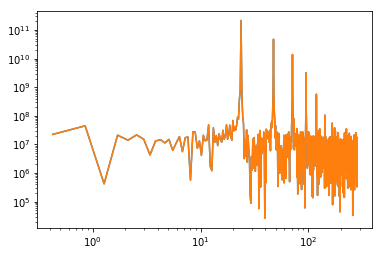

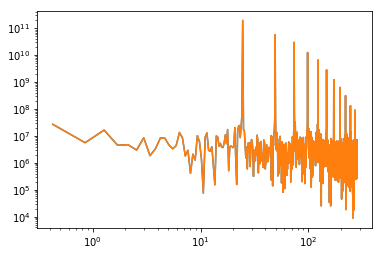

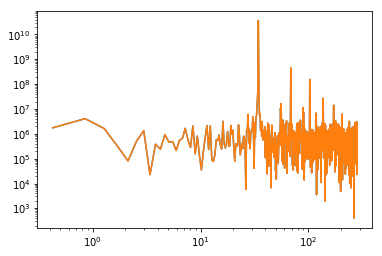

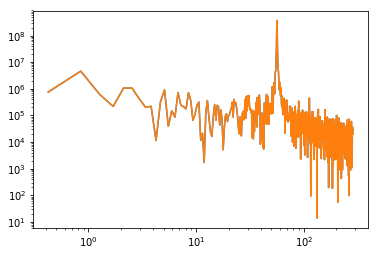

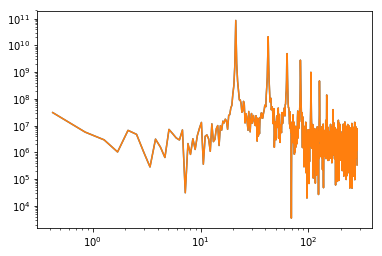

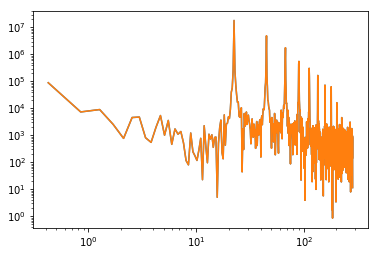

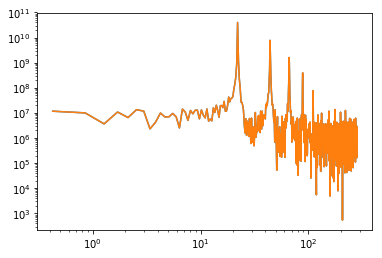

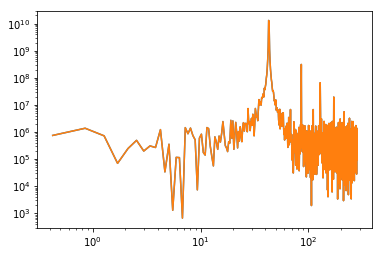

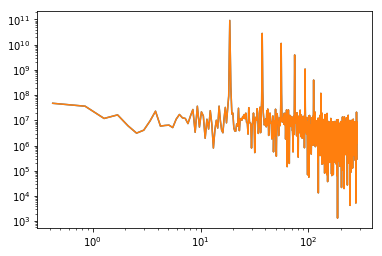

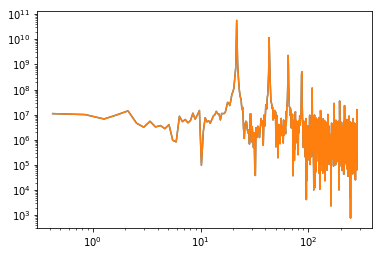

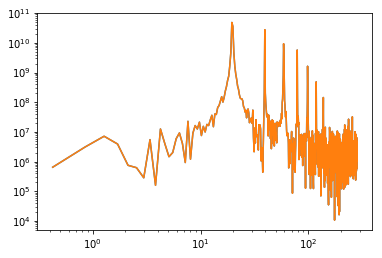

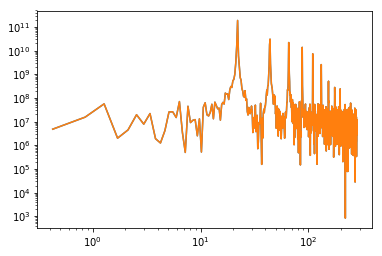

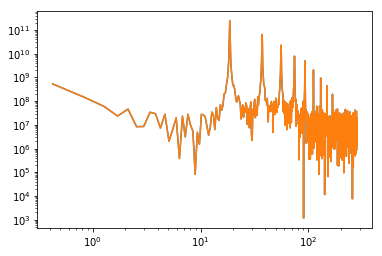

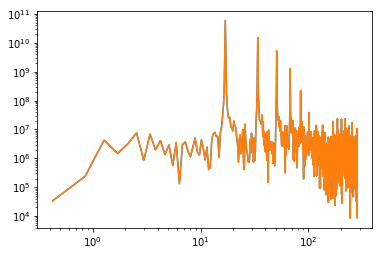

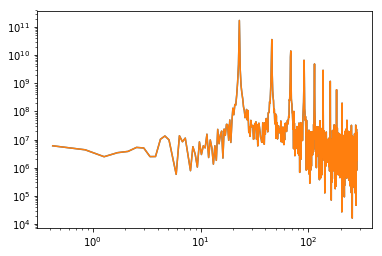

<Figure size 432x288 with 0 Axes>

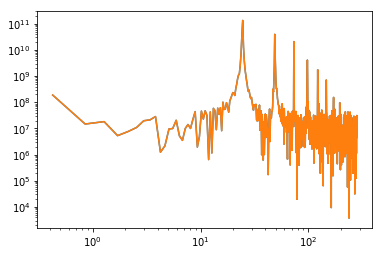

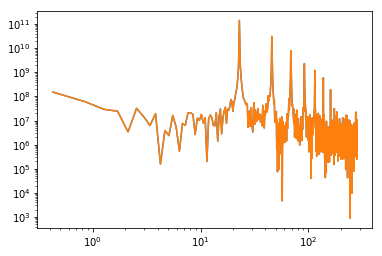

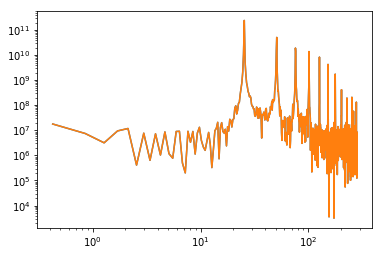

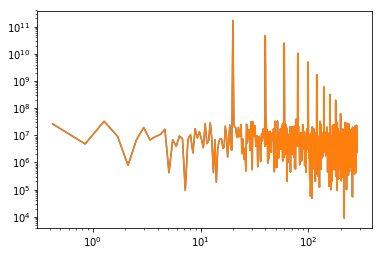

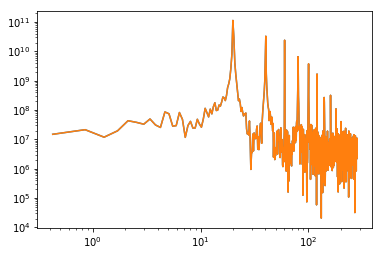

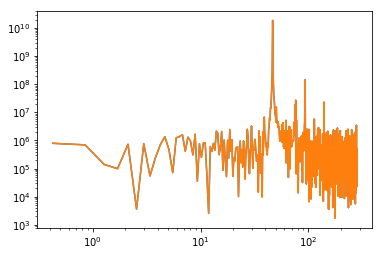

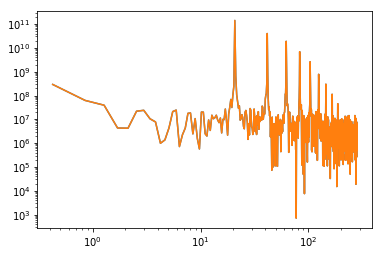

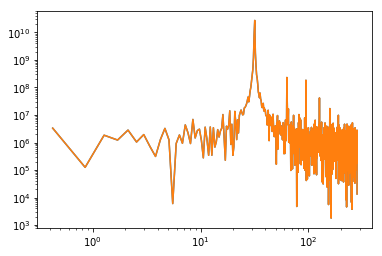

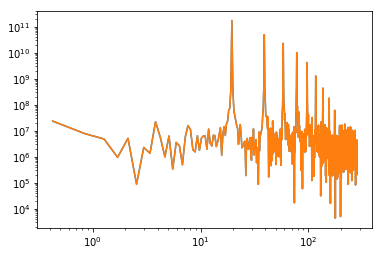

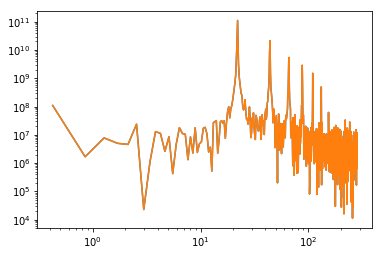

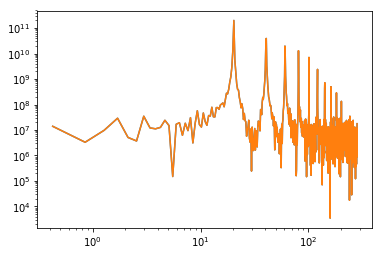

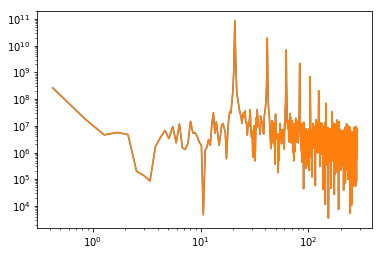

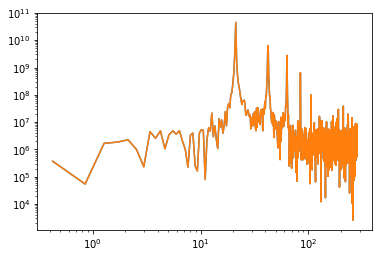

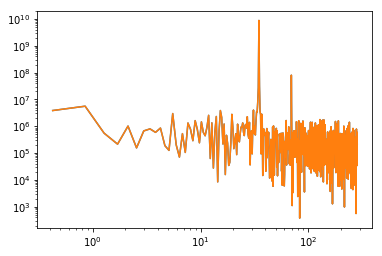

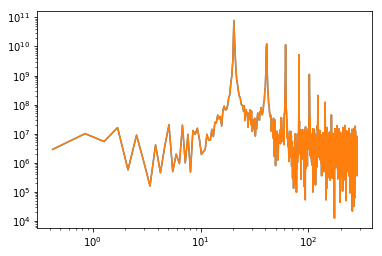

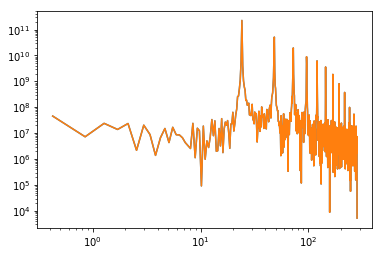

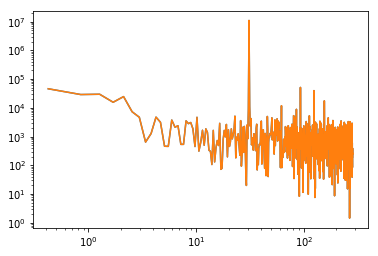

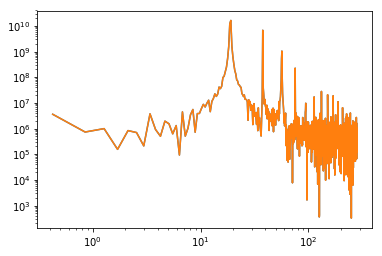

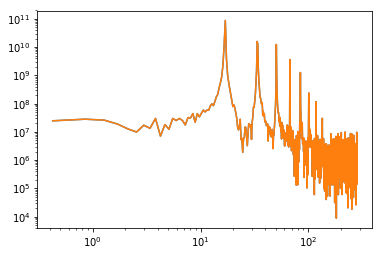

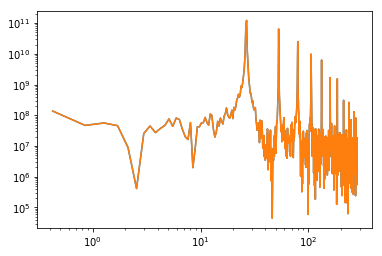

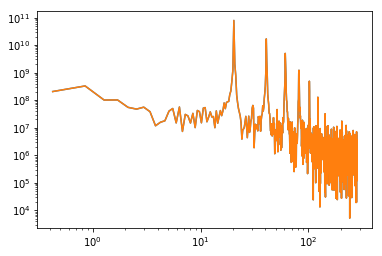

In [24]:
for i in range(len(priority[y == 'RRLyr/Ceph'])):

    try:
        plt.figure()
        with open('../../non_corrupt_starclass/starclass/starclass/training_sets/data/keplerq9/features_cache_corr/features-'+str(priority[y == 'RRLyr/Ceph'][i])+'.pickle', 'rb') as pickle_file:
            feature = pickle.load(pickle_file)
        #print(feature['freq1'])
        #matplotlib.use('TKAgg')
        freq, psd = feature['powerspectrum'].standard

        plt.plot(freq, psd)
        with open('../starclass/training_sets/data/keplerq9/features_cache_corr/features-'+str(priority[y == 'RRLyr/Ceph'][i])+'.pickle', 'rb') as pickle_file:
            feature = pickle.load(pickle_file)
        print(feature['freq1'])
        print(labels.iloc[priority[y == 'RRLyr/Ceph'][i]])
        #matplotlib.use('TKAgg')
        freq, psd = feature['powerspectrum'].standard
        plt.plot(freq, psd)
        #plt.axvline(feature['freq1'], color='r', linestyle='--')
        plt.xscale('log')
        plt.yscale('log')
        plt.show()
    except:
        pass

In [49]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(priority, y):
    X_train = np.zeros([len(train_index), 22])
    X_test = np.zeros([len(test_index), 22])
    y_train = y[train_index]
    y_test = y[test_index]
    print(test_index)
    train = priority[train_index]
    for idx, i in enumerate(train):
        X_train[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
    test = priority[test_index]
    for idx, i in enumerate(test):
        X_test[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
    break

[   2    7   10 ... 5169 5170 5172]


KeyboardInterrupt: 

In [22]:
print(*zip(feature_names, model.feature_importances_))

('freq1', 0.09830404494831756) ('freq2', 0.04911289881073633) ('freq3', 0.0789127259494249) ('freq4', 0.05211929984265933) ('freq5', 0.05287993621002065) ('freq6', 0.08682729959867334) ('freqamp1', 0.017115712820341376) ('freqamp2', 0.019108984590276493) ('phasediff1', 0.02181050143968431) ('phasediff2', 0.02587153130679648) ('somloc1', 0.004750277654742303) ('somloc2', 0.05045198323645449) ('phase1', 0.02411476979472758) ('phase2', 0.014175410842562103) ('p2p1', 0.040310710267025616) ('p2p2', 0.040892411044004456) ('psi', 0.0715521607151531) ('zc', 0.07525855712533552) ('fliper07', 0.056405891376721536) ('fliper7', 0.049838234890872864) ('fliper20', 0.03042509109185909) ('fliper50', 0.03976156644361055)


In [23]:
preds = model.predict(X_test)

In [24]:
accuracy_score(preds, y_test)

0.9913344887348353

In [25]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

starclass


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


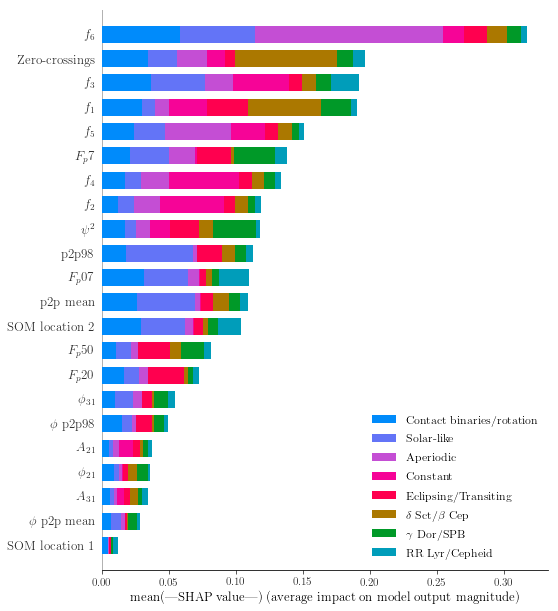

In [42]:
fig = shap.summary_plot(shap_values, X_test, 
                  feature_names=feature_names,
                  class_names=class_names, max_display=len(feature_names))
plt.savefig('RFGC_feature_importance.pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: 

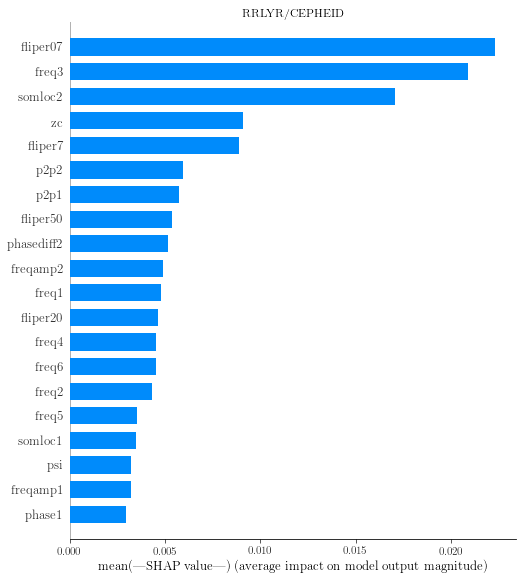

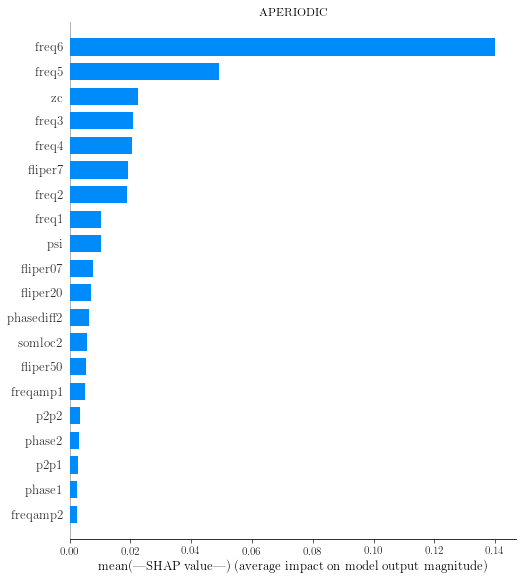

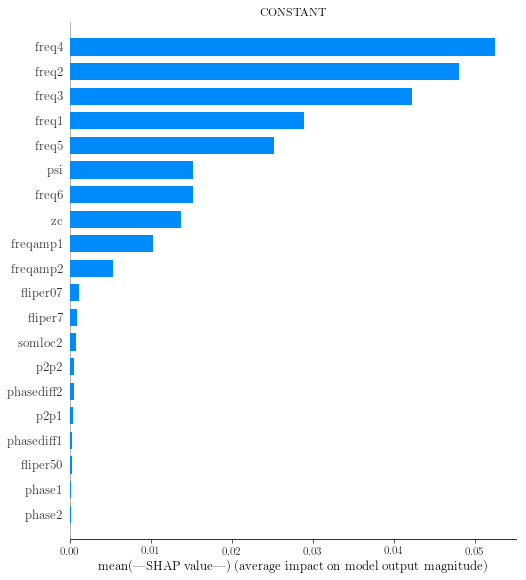

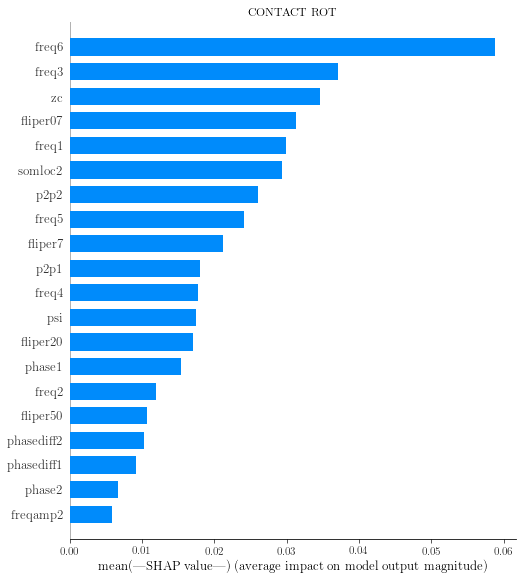

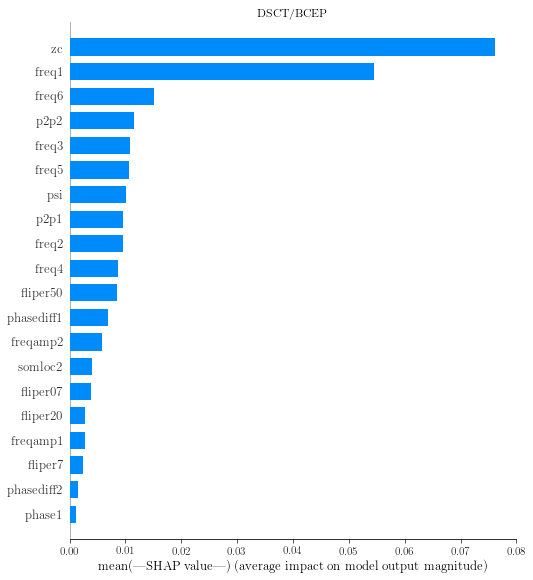

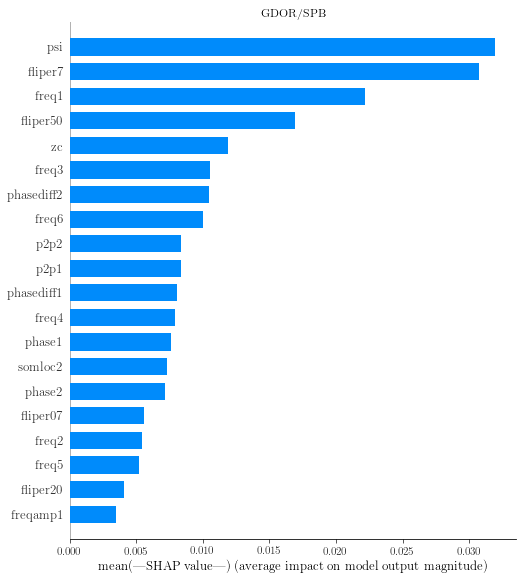

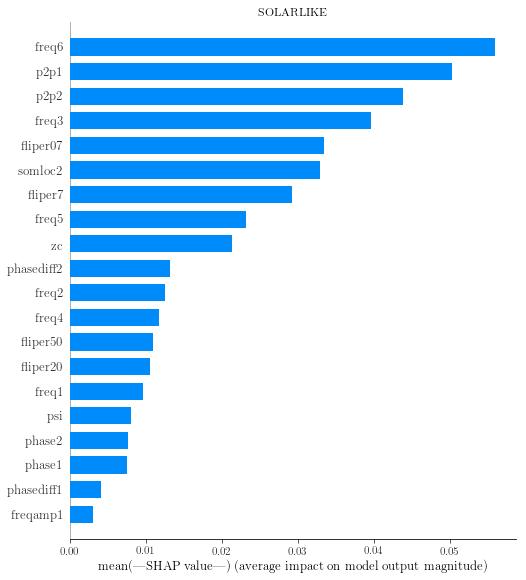

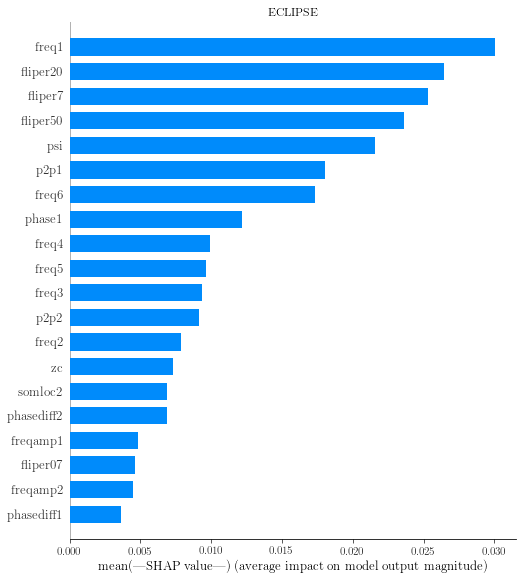

In [27]:
for i in range(len(class_names)):
    plt.figure(i)
    plt.title(class_names[i])
    shap.summary_plot(shap_values[i], X_test, 
                      feature_names=feature_names,
                      class_names=class_names[i], plot_type="bar")
    #plt.savefig(class_names[i]+'.png', bbox_inches='tight')
    plt.show()